<a href="https://colab.research.google.com/github/abhi7251/ChestDiseasePrediction/blob/main/Chest_X_ray_image_disease_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.06G/2.06G [00:14<00:00, 150MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

100%|██████████| 663M/663M [00:06<00:00, 103MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
original_dataset_dir = "/root/.cache/kagglehub/datasets/train_test"  # Your dataset directory with 3 classes
base_dir = "/root/.cache/kagglehub/datasets/split_data"  # Base directory for split datasets
os.makedirs(base_dir, exist_ok=True)

# Create directories for train, val, and test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Split ratios
val_split = 0.2  # 20% for validation
test_split = 0.1  # 10% for testing

# Process each class
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue  # Skip non-directory files

    # Get all image file paths for this class
    image_filenames = os.listdir(class_dir)
    image_paths = [os.path.join(class_dir, fname) for fname in image_filenames]

    # Split into train, temp (validation + test)
    train_paths, temp_paths = train_test_split(
        image_paths, test_size=val_split + test_split, random_state=42
    )

    # Split temp into validation and test
    val_paths, test_paths = train_test_split(
        temp_paths, test_size=test_split / (val_split + test_split), random_state=42
    )

    # Create subdirectories for each class in train, val, and test
    for split_dir, paths in zip([train_dir, val_dir, test_dir], [train_paths, val_paths, test_paths]):
        split_class_dir = os.path.join(split_dir, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for path in paths:
            shutil.copy(path, split_class_dir)

print("Dataset successfully split into train, val, and test directories.")

# Image size and batch size
image_size = (160, 160)
batch_size = 32
epochs = 20

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom-in/out
    horizontal_flip=True  # Randomly flip images horizontally
)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
)

# Test data generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # Convert images to grayscale
)

# Map class indices to class labels
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

# Count the number of images per class in the training set
train_class_counts = {class_name: list(train_generator.classes).count(idx)
                      for class_name, idx in train_generator.class_indices.items()}
print("Training Class Counts:", train_class_counts)

# Count the number of images per class in the validation set
validation_class_counts = {class_name: list(val_generator.classes).count(idx)
                           for class_name, idx in val_generator.class_indices.items()}
print("Validation Class Counts:", validation_class_counts)

# Count the number of images per class in the test set
test_class_counts = {class_name: list(test_generator.classes).count(idx)
                     for class_name, idx in test_generator.class_indices.items()}
print("Test Class Counts:", test_class_counts)


Dataset successfully split into train, val, and test directories.
Found 4088 images belonging to 4 classes.
Found 1169 images belonging to 4 classes.
Found 587 images belonging to 4 classes.
Class Indices: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'Tuberculosis': 3}
Training Class Counts: {'COVID19': 321, 'NORMAL': 886, 'PNEUMONIA': 2392, 'Tuberculosis': 489}
Validation Class Counts: {'COVID19': 92, 'NORMAL': 253, 'PNEUMONIA': 684, 'Tuberculosis': 140}
Test Class Counts: {'COVID19': 47, 'NORMAL': 127, 'PNEUMONIA': 342, 'Tuberculosis': 71}


In [ ]:
# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(4, activation='softmax')  # Output layer for 3 classes
])

from tensorflow.keras.metrics import Precision, Recall

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 158, 158, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 77, 77, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,401,732 (20.61 MB)

 Trainable params: 5,401,732 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5993 - loss: 1.0520 - precision: 0.6471 - recall: 0.3958
Epoch 1: val_accuracy improved from -inf to 0.75620, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 86s 583ms/step - accuracy: 0.5999 - loss: 1.0502 - precision: 0.6483 - recall: 0.3971 - val_accuracy: 0.7562 - val_loss: 0.6917 - val_precision: 0.8722 - val_recall: 0.5894
Epoch 2/20
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7121 - loss: 0.6956 - precision: 0.8017 - recall: 0.6203
Epoch 2: val_accuracy improved from 0.75620 to 0.76818, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 67s 502ms/step - accuracy: 0.7122 - loss: 0.6954 - precision: 0.8017 - recall: 0.6206 - val_accuracy: 0.7682 - val_loss: 0.5960 - val_precision: 0.8235 - val_recall: 0.7143
Epoch 3/20
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7547 - loss: 0.6310 - precision: 0.8211 - recall: 0.6815
Epoch 3: val_accuracy improved from 0.76818 to 0.78443, s

In [ ]:
# Evaluate on the validation set
results = model.evaluate(val_generator)
val_loss = results[0]  # First value is loss
val_accuracy = results[1]  # Second value is accuracy
val_precision = results[2]  # Third value is precision
val_recall = results[3]  # Fourth value is recall

# Print validation metrics
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_precision * 100:.2f}%")
print(f"Validation Recall: {val_recall * 100:.2f}%")


37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.9125 - loss: 0.2407 - precision: 0.9147 - recall: 0.9057
Validation Loss: 0.260658860206604
Validation Accuracy: 91.45%
Validation Precision: 91.63%
Validation Recall: 90.85%


In [ ]:
# Evaluate on the test set
results = model.evaluate(test_generator)
test_loss = results[0]  # First value is loss
test_accuracy = results[1]  # Second value is accuracy
test_precision = results[2]  # Third value is precision
test_recall = results[3]  # Fourth value is recall

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.9176 - loss: 0.2113 - precision: 0.9176 - recall: 0.9129
Test Loss: 0.22098445892333984
Test Accuracy: 92.33%
Test Precision: 92.45%
Test Recall: 91.82%


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.9164 - loss: 0.2224 - precision: 0.9170 - recall: 0.9087
Test Loss: 0.22098445892333984
Test Accuracy: 92.33%
Test Precision: 92.45%
Test Recall: 91.82%


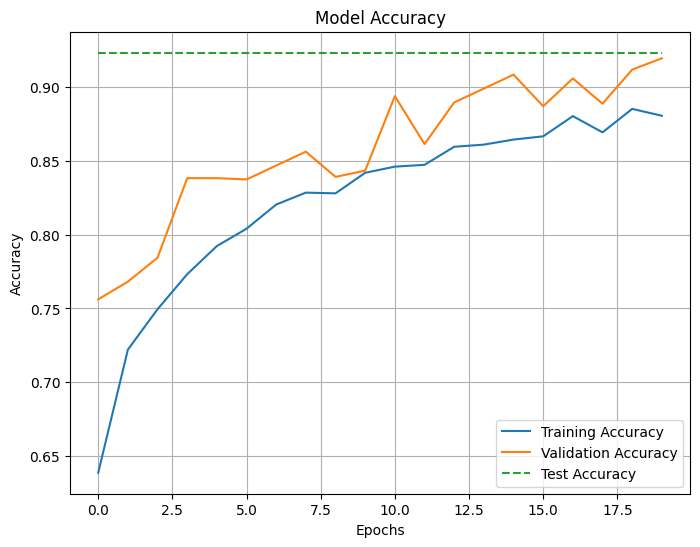

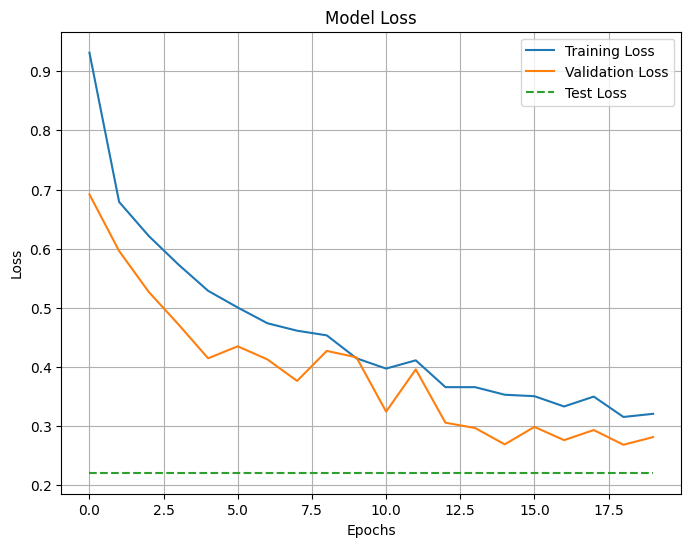

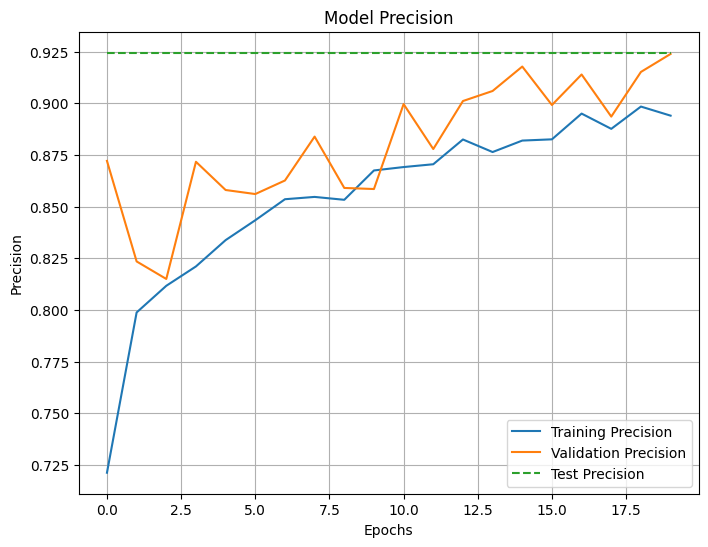

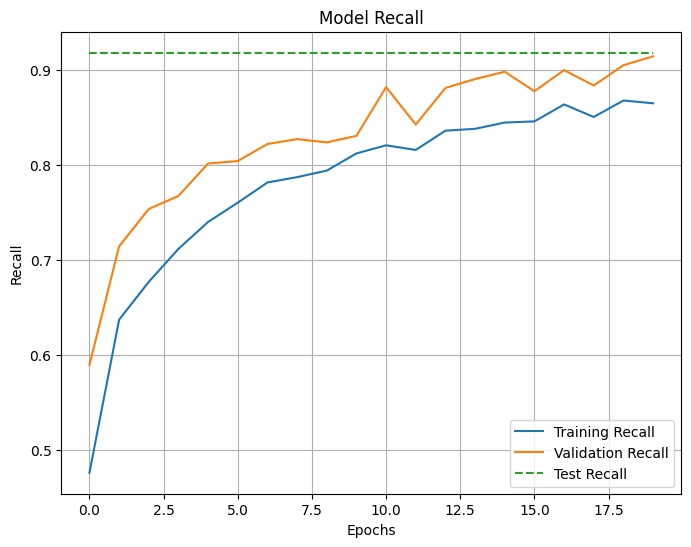

In [ ]:
# Evaluate test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

# Print test metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

# Store test metrics in history manually to include in graphs
history.history['test_loss'] = [test_loss] * len(history.history['loss'])
history.history['test_accuracy'] = [test_accuracy] * len(history.history['accuracy'])
history.history['test_precision'] = [test_precision] * len(history.history['precision'])
history.history['test_recall'] = [test_recall] * len(history.history['recall'])

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['test_accuracy'], label='Test Accuracy', linestyle='--')  # Test Accuracy
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['test_loss'], label='Test Loss', linestyle='--')  # Test Loss
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision
plt.figure(figsize=(8, 6))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['test_precision'], label='Test Precision', linestyle='--')  # Test Precision
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Plot recall
plt.figure(figsize=(8, 6))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.plot(history.history['test_recall'], label='Test Recall', linestyle='--')  # Test Recall
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/trained_model.keras')  # Save in native Keras format
# if os.path.exists('/content/trained_model.keras'):
#     print("Model saved at: /content/trained_model.keras")
# else:
#     print("Model not found.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

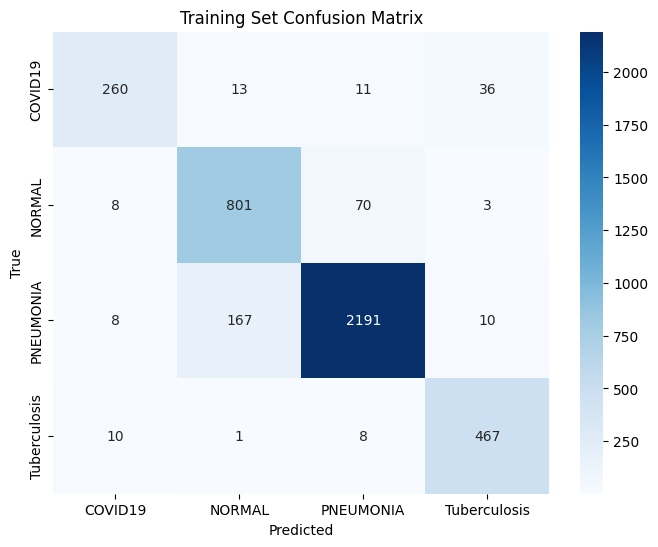

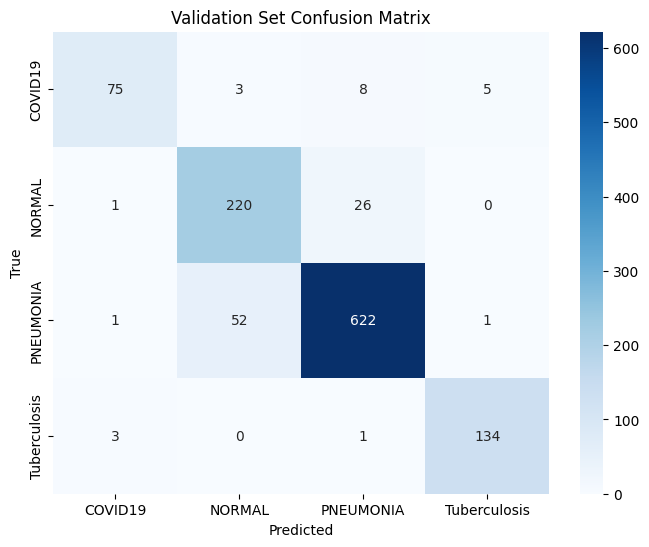

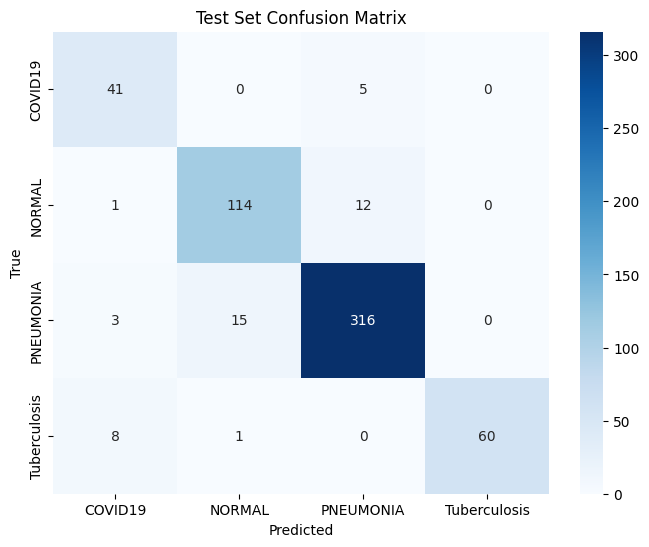

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to collect true labels and predictions for a generator
def get_true_labels_and_predictions(generator):
    true_labels = []
    predictions = []

    # Iterate through the generator
    for i in range(generator.samples // generator.batch_size):
        x_batch, y_batch = next(generator)  # Get the next batch
        preds = model.predict(x_batch)  # Get predictions for the batch
        preds = np.argmax(preds, axis=1)  # Convert to class labels

        true_labels.extend(np.argmax(y_batch, axis=1))  # Get true class labels
        predictions.extend(preds)  # Store predictions

    return np.array(true_labels), np.array(predictions)

# Get true labels and predictions for the training, validation, and test sets
train_true, train_preds = get_true_labels_and_predictions(train_generator)
val_true, val_preds = get_true_labels_and_predictions(val_generator)
test_true, test_preds = get_true_labels_and_predictions(test_generator)

# Get class labels (the order of the classes in the generator)
class_labels = list(train_generator.class_indices.keys())

# Plot confusion matrix for training, validation, and test sets
plot_confusion_matrix(train_true, train_preds, class_labels, 'Training Set Confusion Matrix')
plot_confusion_matrix(val_true, val_preds, class_labels, 'Validation Set Confusion Matrix')
plot_confusion_matrix(test_true, test_preds, class_labels, 'Test Set Confusion Matrix')
